In [1]:
# Third party import
import pysap
from pysap.data import get_sample_data
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from etomo.operators import Radon2D, WaveletPywt, HOTV
from etomo.reconstructors.forwardradon import RadonReconstructor

In [3]:
# Loading input data
image = get_sample_data('2d-mri')
img_size = image.shape[0]

In [4]:
# Create radon operator and simulate data
theta = np.arange(0., 180., 3.)
radon_op = Radon2D(angles=theta, img_size=img_size, gpu=True)
data = radon_op.op(image)

In [10]:
# Create operators: we give Identity to SparseThreshold as the inputs it will
# be given will already be in the linear operator's image space
TV = HOTV(img_shape=image.shape, order=2)
wavelet = WaveletPywt(wavelet_name='sym8', nb_scale=3)
linear_op = wavelet

In [11]:
regularizer_op = SparseThreshold(linear=Identity(), weights=2e-6)
reconstructor = RadonReconstructor(
    data_op=radon_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
)

In [12]:
# Run reconstruction
x_final, cost, *_ = reconstructor.reconstruct(
    data=data,
    optimization_alg='condatvu',
    num_iterations=300,
    cost_op_kwargs={'cost_interval': 5}
)

100% (300 of 300) |######################| Elapsed Time: 0:00:12 Time:  0:00:12


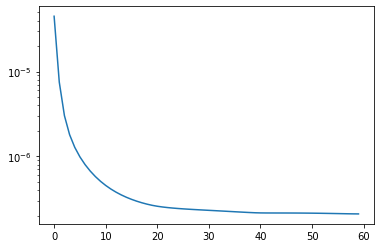

The Reconstruction SSIM is:  0.853015


In [14]:
# Results
plt.plot(cost)
plt.yscale('log')
plt.show()
image_rec = pysap.Image(data=x_final)
image_rec.show()
recon_ssim = ssim(image_rec, image)
#print('The Reconstruction SSIM is : ' + str(recon_ssim))
print(f'The Reconstruction SSIM is: {recon_ssim: 2f}')